In [104]:
from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO
from lxml import etree
import random
from tqdm import tqdm
import pandas as pd
import spacy
import treetaggerwrapper
import numpy as np
import matplotlib.pyplot as plt

def config():
    return {
        "debug": False
    }


def load_files(path, debug=True):

    zipped_ressource = ZipFile(path)

    namelist = zipped_ressource.namelist()
    if debug:
        namelist = random.sample(namelist, 50)

    for name in namelist:
        if "/simple/" not in name:
            yield zipped_ressource.open(name).read(), name.split("_")[-1][:-8]
    


def dta_loader():

    online_ressource = "/Users/davidlassner/research/conferences_and_papers/talks/2019 DH_workshop/spaCy_DH2019_workshop/unit2/dta/dta_kernkorpus_2018-10-18_tcf.zip"
    
    for file_bytes, year in load_files(online_ressource, debug=config()["debug"]):
        try:
            yield etree.XML(file_bytes), year
        except etree.XMLSyntaxError:
            print("XMLSyntaxError")

            
def iterate_file(f):
    
    tokens_lookup = {t.attrib["ID"]:t.text.strip() for t in f.xpath(".//dspt:token", namespaces=spec) if t.text is not None}
    lemmata_lookup = {l.attrib["tokenIDs"]:l.text.strip() for l in f.xpath(".//dspt:lemma", namespaces=spec) if l.text is not None}
    tags_lookup = {t.attrib["tokenIDs"]:t.text.strip() for t in f.xpath(".//dspt:tag", namespaces=spec) if t.text is not None}
    
    sents = f.xpath(".//dspt:sentence", namespaces=spec)
    random.shuffle(sents)

    for sent in sents:
        try:
            token, lemmata, tags = [], [], []
            for t_id in sent.attrib["tokenIDs"].split(" "):
                token.append(tokens_lookup[t_id])
                lemmata.append(lemmata_lookup[t_id])
                tags.append(tags_lookup[t_id])
            yield token, lemmata, tags
        except KeyError:
            pass

In [112]:
spec = {"dspt":"http://www.dspin.de/data/textcorpus"}

dataset = []
num_records = 0
num_files = 0
#pbar = tqdm()

# spacy
nlp = spacy.load("de")
# treetagger
tagger = treetaggerwrapper.TreeTagger(TAGLANG='de')

for f, year in dta_loader():
    num_files += 1

    for token, lemmata, tags in iterate_file(f):
        #pbar.update(1)
        if num_records % 5000 == 0:
            print(num_files, num_records)
        
        source_sent = ""
        for i, (to,le,tg) in enumerate(zip(token, lemmata, tags)):
            if i != 0 and tg not in ["$.", "$,", "$;", "$(", "$:"]:
                source_sent += " " + to
            else:
                source_sent += to

        
        dataset.append({
            "sentence": source_sent,
            "lemmata_cab": lemmata,
            "lemmata_spacy": [x_.lemma_ for x_ in nlp(source_sent)],
            "lemmata_treetagger": [t.split("\t")[2] for t in tagger.tag_text(source_sent) if len(t.split("\t")) == 3],
            "year": int(year)
        })
        num_records += 1
        if num_records/num_files > 3000:
            break

XMLSyntaxError
XMLSyntaxError
1 0
2 5000
4 10000
5 15000
7 20000
10 25000
11 30000
15 35000
18 40000
19 45000
20 50000
21 55000
22 60000
23 65000
24 70000
25 75000
29 80000
32 85000
34 90000
35 95000
36 100000
36 105000
37 110000
39 115000
42 120000
44 125000
46 130000
49 135000
51 140000
53 145000
53 150000
53 155000
54 160000
58 165000
59 170000
63 175000
64 180000
65 185000
68 190000
70 195000
71 200000
71 205000
71 210000
73 215000
74 220000
75 225000
77 230000
79 235000
83 240000
85 245000
87 250000
90 255000
92 260000
93 265000
95 270000
96 275000
97 280000
98 285000
99 290000
99 295000
101 300000
102 305000
104 310000
105 315000
108 320000
109 325000
110 330000
112 335000
114 340000
116 345000
119 350000
121 355000
122 360000
123 365000
125 370000
127 375000
128 380000
130 385000
132 390000
134 395000
135 400000
137 405000
138 410000
140 415000
142 420000
143 425000
146 430000
146 435000
147 440000
149 445000
150 450000
153 455000
154 460000
156 465000
157 470000
159 475000
160 

KeyboardInterrupt: 

In [113]:
dataset = pd.DataFrame(dataset)
dataset.index = dataset['year'] 
dataset.head()

,lemmata_cab,lemmata_spacy,lemmata_treetagger,sentence,year
year,,,,,
1796,"[d, erst, beide, Frau, sein, mit, eine, einzig...","[der, erſten, beid, Frau, sein, mit, einer, ei...","[die, erſten, beide, Frau, sein, mit, eine, ei...",Die erſten beiden Frauen waren mit einem einzi...,1796
1796,"[Schnelle, Vorkehrung, können, sie, noch, rett...","[schnell, Vorkehrung, konte, ſie, noch, retten...","[schnell, Vorkehrung, konte, ſie, noch, retten...",Schnelle Vorkehrung konte ſie noch retten.,1796
1796,"[zehn, bringen, er, gleich, drauf, seine, eige...","[Zen, *, *, bringen, ich, gleichen, drauf, ſei...","[Zen, *, *, bringen, er, gleich, drauf, ſeine,...",Zen** brachte ihm gleich drauf ſeine eignen Fi...,1796
1796,"[diese, zweit, Brief, kommen, in, Albemannen, ...","[Dieſer, zweite, Brief, kommen, in, Albemanens...","[Dieſer, zweit, Brief, kommen, in, Albemanens,...",Dieſer zweite Brief kam in Albemanens Abweſenh...,1796
1796,"[selbst, jene, Lehmann, ,, die, ,, eine, Schle...","[Selbſt, jen, Lehmann, ,, der, ,, einen, Schle...","[Selbſt, jen, Lehmann, ,, die, ,, eine, Schleſ...","Selbſt jenes Lehmanns, der, ein Schleſier von ...",1796


In [114]:
s_cab = dataset.lemmata_cab.apply(set)
s_spacy = dataset.lemmata_spacy.apply(set)
s_tt = dataset.lemmata_treetagger.apply(set)

dataset["spacy_cab_overlap"] = dataset.T.apply(
    lambda row: len(set(row.lemmata_spacy) & set(row.lemmata_cab)) / len(row.lemmata_cab)
)

dataset["treetagger_cab_overlap"] = dataset.T.apply(
    lambda row: len(set(row.lemmata_treetagger) & set(row.lemmata_cab)) / len(row.lemmata_cab)
)


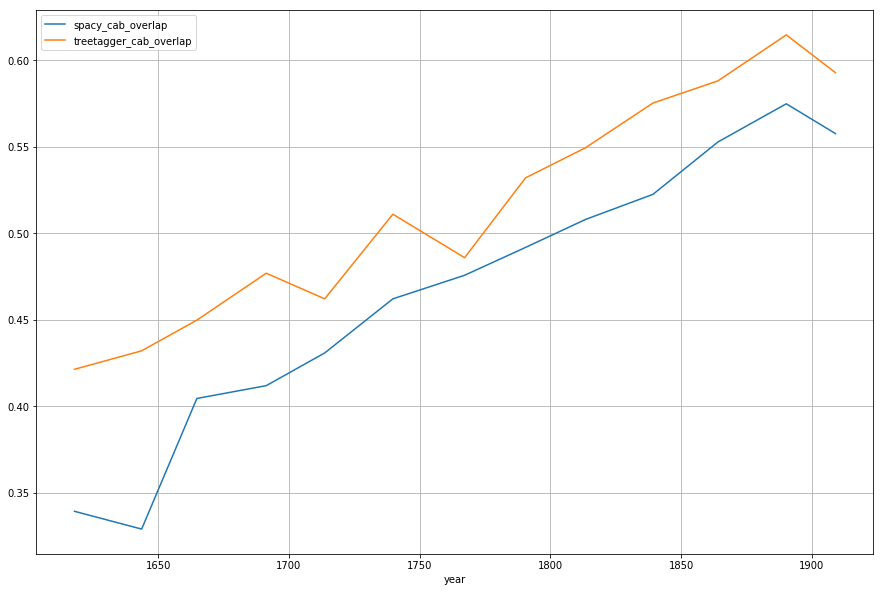

In [130]:
#dataset.resample("25Y").mean().plot()


s = ((dataset.index.to_series() - dataset.index.min()) / 25).astype(int)
dataset.groupby(s).mean().plot(x='year', y=['spacy_cab_overlap', 'treetagger_cab_overlap'],  figsize=(15,10), grid=True)